In [1]:
%matplotlib notebook
from PIL import Image, ImageTk
import tkinter as tk
import numpy as np
from cv2 import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import time

In [3]:
# Setup MediaPipe Hands
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    min_detection_confidence=0.6, min_tracking_confidence=0.75, max_num_hands=1
)

# OpenCV video stream at 20 fps.
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, 20) 

True

In [16]:
def fetch_hand():
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        return None
    # Flip the image horizontally for a later selfie-view display, and convert
    # the BGR image to RGB.
    image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    results = hands.process(image)
    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
        wrist = results.multi_hand_landmarks[0].landmark[mp_hands.HandLandmark.WRIST]
        wrist = (wrist.x, wrist.y, wrist.z)
        hand = []
        for hand_landmarks in results.multi_hand_landmarks:
            for i in hand_landmarks.ListFields()[0][1]:
                # Add each point to the hand array, normalized relative to the anchor.
                hand.append((i.x, i.y, i.z)) #hand.append((np.subtract((i.x, i.y, i.z), wrist)))
            hand = np.array(hand)
            mp_drawing.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            return hand
    return None

In [9]:
def angle(a,b,c):
    ba=a-b
    bc=c-b
    cos_a = np.dot(ba,bc)/(np.linalg.norm(ba)*np.linalg.norm(bc))
    return np.degrees(np.arccos(cos_a))

def translation(a,b):
    return np.subtract(a[0],b[0])

<IPython.core.display.Javascript object>


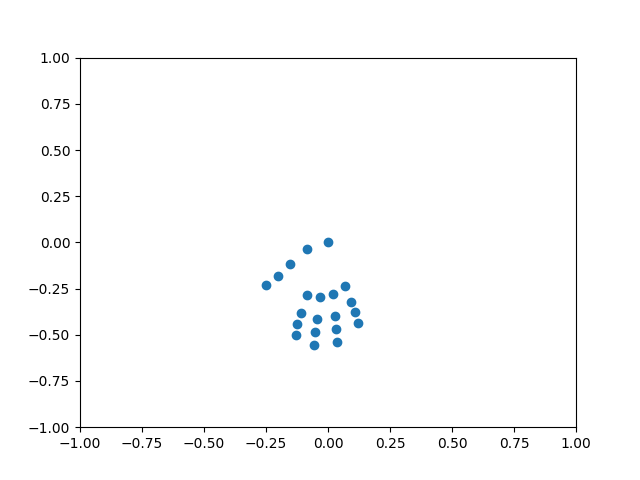

In [6]:
fig, ax = plt.subplots()
x = [0]*21
y = [0]*21
sc = ax.scatter(x,y)
plt.xlim(-1,1)
plt.ylim(-1,1)
def animate(i):
    hand = fetch_hand()
    if not hand is None:
        sc.set_offsets(hand[:,:2])

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=100, interval=20, repeat=True) 
plt.show()

<IPython.core.display.Javascript object>


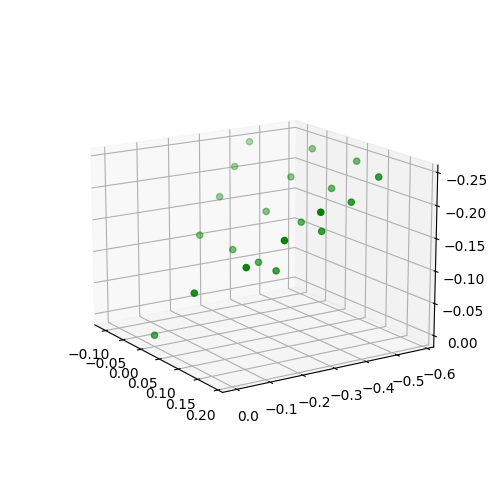

In [32]:
hand = fetch_hand()
fig = plt.figure(figsize = (5, 5))
ax = plt.axes(projection ="3d")
x, y, z = hand.T
# Creating plot
ax.scatter3D(x, y, z, color = "green")
 
# show plot
plt.show()

In [19]:
from IPython.display import clear_output

def finger_angle(base):
    return min(round(angle(hand[base],hand[base+1],hand[base+2]),3),round(angle(hand[base+1],hand[base+2],hand[base+3]),3))

def is_bent(angle):
    if angle < 155:
        return True
    return False

last = None
while True:
    time.sleep(0.1)
    hand = fetch_hand()
    if hand is not None:
        clear_output(wait=True)
        angles = [finger_angle(1),finger_angle(5),finger_angle(9),finger_angle(13),finger_angle(17)]
        print(angles)#["Is bent" if is_bent(a) else "Unbent " for a in angles])
        if last is not None:
            d = translation(last,hand)
            print(round(d[0],3),round(d[1],3),round(d[2],3))
        last = hand

[163.516, 169.72, 165.842, 167.372, 171.448]
0.001 0.0 -0.0


KeyboardInterrupt: 

In [35]:
cap.release()